# Asymmetry `n_m_bg_start=1`

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import lightkurve as lk
from matplotlib import pyplot as  plt
import numpy as np
from astropy.table import Table
from analysis_tools_cython import *
import scipy.integrate as integrate
import numpy as np
from scipy.signal import savgol_filter

plt.rcParams["figure.figsize"] = (10, 6)

## Functions

In [3]:
def skewed_gaussian_curve_fit(x,y):
    # Initial parameters guess
    ## i = index of min time
    ## x = time
    ## y = flux
    
    i = np.argmin(y)
    
    ### params initialisation for skewness, time, mean and sigma
    params_init = [1,x[i],0.1,0.0001] # i find these good to initialise with
    
    #params_bounds = [[0,x[0],0,-np.inf], [np.inf,x[-1],np.inf,np.inf]]
    params,cov = curve_fit(updated_skewed_gauss,x,y,p0=params_init,maxfev=1000000)#,bounds=params_bounds)
    return params, cov 

def skewed_gaussian(x,a,mean,sigma,m):
    """
    m: amplitude
    x: time
    a: skewness
    mean: time
    sigma: sigma/standard deviation    
    
    """
    return -m * skewnorm.pdf(x,a,loc=mean,scale=sigma)

def lookup_tic(tic):
    return lookup[lookup.TIC_ID == tic]

def search_method(data):
    try:
        data = data['time','corrected flux','quality','flux error']
    except:
        data = data['TIME','PDCSAP_FLUX','QUALITY','PDCSAP_FLUX_ERR']

    flat_flux, trend_flux = smoothing(data,method='median')
    a = Table()
    a['time'] = data[data.colnames[0]]
    a['flux'] = flat_flux - np.ones(len(flat_flux))
    a['quality'] = data[data.colnames[2]]
    a['flux_error'] = data[data.colnames[3]]
    #table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
    t, flux, quality, real, flux_error = clean_data(a)
    flux *= real
    timestep = calculate_timestep(data)
    factor = ((1/48)/timestep)

    T1 = test_statistic_array(flux,60 * factor)

    m, n = np.unravel_index(
    T1.argmin(), T1.shape
    )  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
    minT = T1[m, n]
    #Ts = nonzero(T1[m,n]).std()
    minT_time = t[n]
    minT_duration = m * timestep
    Tm_start = n-math.floor((m-1)/2)
    Tm_end = Tm_start + m
    Tm_depth = flux[Tm_start:Tm_end].mean() 
    Ts = nonzero(T1[m]).std() # only the box width selected. Not RMS of all T-statistic
    
    asym, width1, width2, depth, info = calc_shape(m,n,t,flux,quality,flux_error,n_m_bg_start=1)
    return info[0], info[1]

def plot(data):
    time, flux = search_method(data)
    fig, ax = plt.subplots(1,2,figsize=(15,7))
    try:
        ax[0].plot(data["time"],data["corrected flux"])
    except:
        ax[0].plot(data["TIME"],data["PDCSAP_FLUX"])
    ax[1].plot(time,flux)
    ax[1].plot(time,fit,label='gaussian')
    ax[1].plot(time,fit2,color='black',label='skewed gaussian')
    ax[1].legend()
    plt.show()

In [4]:
lookup = pd.read_csv("/storage/astro2/phrdhx/tesslcs/sector1lookup.csv")

## Example 1

In [5]:
data, lc_info = import_lightcurve("betapic/test/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits")

In [6]:
time, flux = search_method(data)

In [7]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit(time,flux)

In [8]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 2.892+/-0.116


In [9]:
fit = -gauss(time,*params)
fit2 = updated_skewed_gauss(time,*params1)

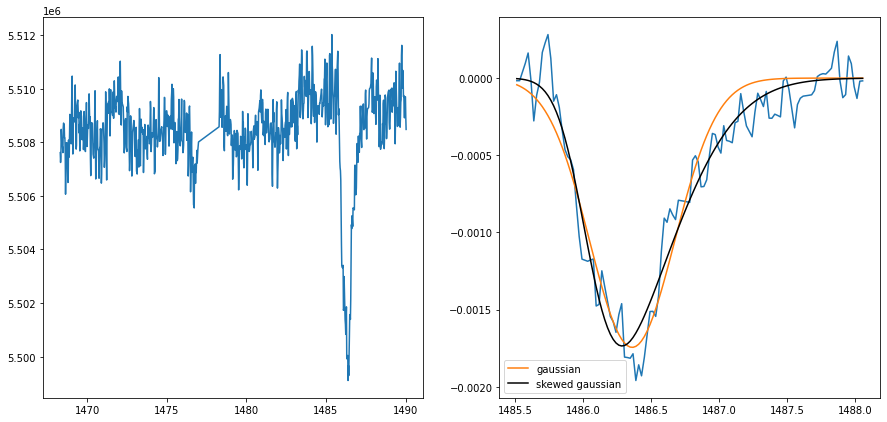

In [10]:
plot(data)

In [11]:
len(flux)

123

### 1a. Flip this lightcurve to see if the skew works in reverse as well

In [12]:
data = data.to_pandas()

In [13]:
data.head()

,TIME,PDCSAP_FLUX,QUALITY,PDCSAP_FLUX_ERR
0,1468.304154,5507612.0,0,64.862846
1,1468.324987,5507246.5,0,64.860832
2,1468.345820,5507478.5,0,64.863037
3,1468.366654,5508482.0,0,64.867645
4,1468.408320,5507866.5,0,64.860580


In [14]:
data.PDCSAP_FLUX = data.PDCSAP_FLUX.values[::-1]

In [15]:
data = Table.from_pandas(data)

In [16]:
time, flux = search_method(data)

In [17]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit(time,flux)

In [18]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is -1.613+/-0.152


In [19]:
fit = -gauss(time,*params)
fit2 = updated_skewed_gauss(time,*params1)

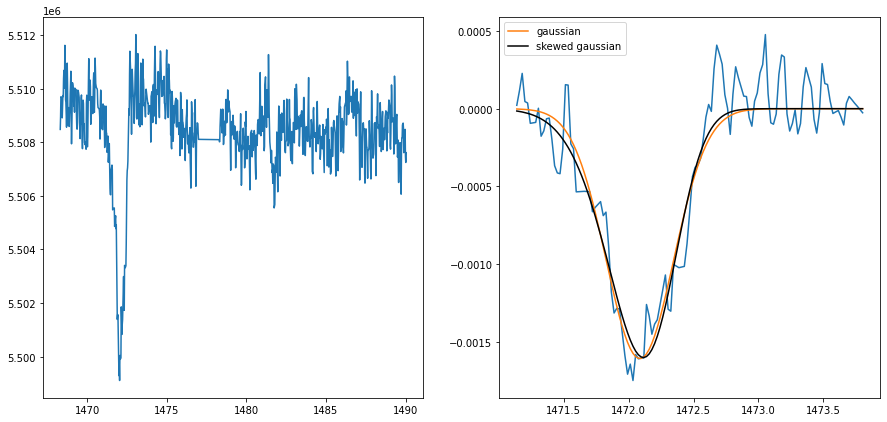

In [20]:
plot(data)

Fits the data quite well.

### Goodness of fit of model

In [21]:
chisquare = np.sum(((flux - fit2)**2)/fit2)

In [22]:
chisquare

-31275219.74550309

---

## Example 2 (CTOI)

In [23]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_50380257.pkl",sector=1)

In [24]:
time, flux = search_method(data)

In [25]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit(time,flux)

In [26]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 2.628+/-0.608


In [27]:
fit = -gauss(time,*params)
fit2 = updated_skewed_gauss(time,*params1)

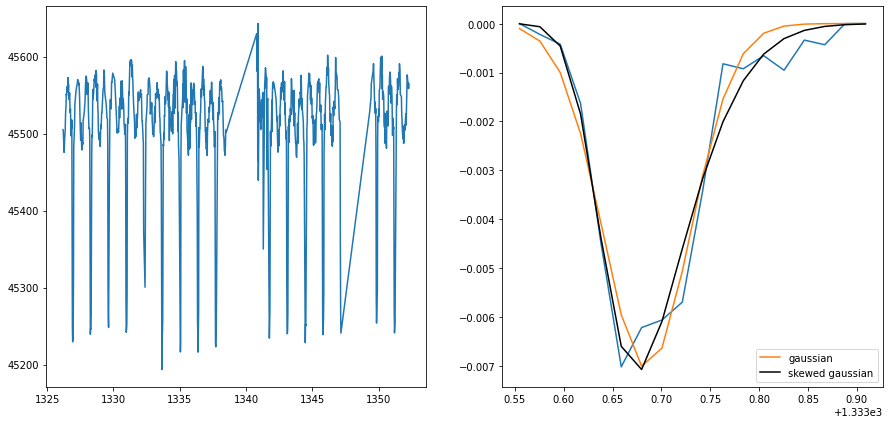

In [28]:
plot(data)

In [29]:
len(flux)

18

---
## Example 3 (CTOI)

In [30]:
lookup_tic(55659311)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12943,tesslcs_sector_1_104/2_min_cadence_targets/tes...,74.117326,-64.48753,55659311,1,4,1,9.7909


In [31]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_55659311.pkl",sector=1)

In [32]:
time, flux = search_method(data)

In [33]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit(time,flux)

In [34]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 0.051+/-603.426


In [35]:
fit = -gauss(time,*params)
fit2 = updated_skewed_gauss(time,*params1)

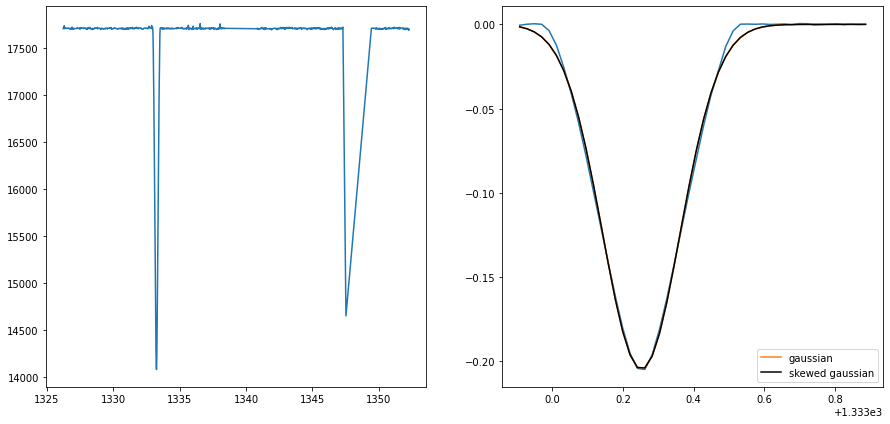

In [36]:
plot(data)

In [37]:
len(flux)

48

---
## Example 4 (EA2)

In [38]:
lookup_tic(60646247)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
53662,tesslcs_sector_1_104/tesslcs_tmag_11_12/tesslc...,334.360488,-33.134487,60646247,1,1,2,11.851


In [39]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/tesslcs_tmag_11_12/tesslc_60646247.pkl",sector=1)

In [40]:
time, flux = search_method(data)

In [41]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit(time,flux)

In [42]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 0.006+/-7327607.188


In [43]:
fit = -gauss(time,*params)
fit2 = updated_skewed_gauss(time,*params1)

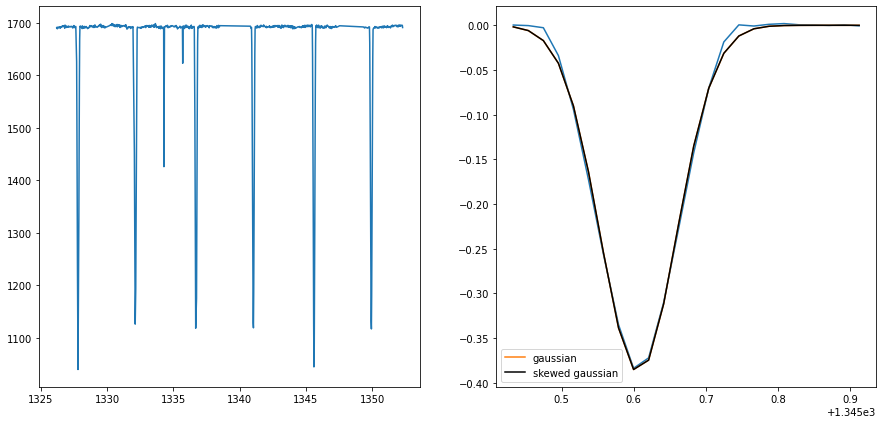

In [44]:
plot(data)

In [45]:
len(flux)

24

---
## Example 5 (WASP 100)

In [46]:
lookup_tic(38846515)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12850,tesslcs_sector_1_104/2_min_cadence_targets/tes...,68.959709,-64.027037,38846515,1,4,1,10.3157


In [47]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_38846515.pkl",sector=1)

In [48]:
time, flux = search_method(data)

In [49]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit(time,flux)

In [50]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 14136.471+/-1.6927554804220616e+16


In [51]:
params

array([8.41870193e-03, 1.32674538e+03, 4.22183905e-02])

In [52]:
fit = -gauss(time,*params)
fit2 = updated_skewed_gauss(time,*params1)

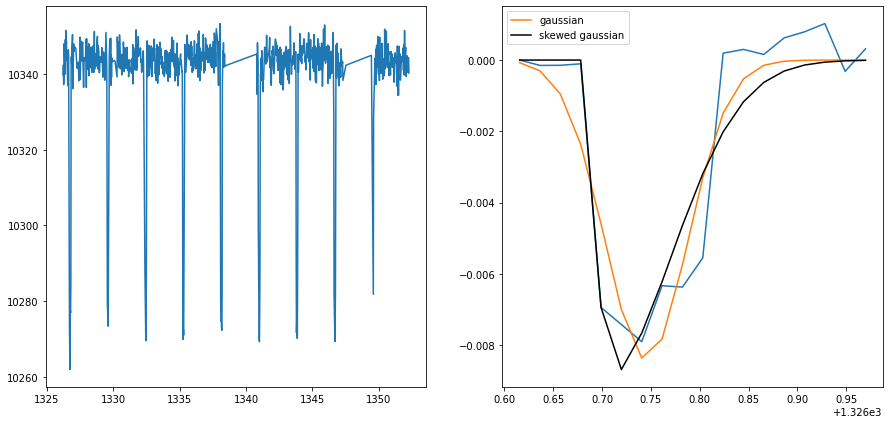

In [53]:
plot(data)

In [54]:
len(flux)

18

---
## Example 6

In [55]:
lookup_tic(61178236)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
43296,tesslcs_sector_1_104/tesslcs_tmag_10_11/tesslc...,334.803809,-31.688934,61178236,1,1,2,10.8952


In [56]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/tesslcs_tmag_10_11/tesslc_61178236.pkl",sector=1)

In [57]:
time, flux = search_method(data)

In [58]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit(time,flux)

In [59]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 985.705+/-6147441880016.211


In [60]:
params

array([1.27796961e-01, 1.34507984e+03, 3.19979102e-02])

In [61]:
fit = -gauss(time,*params)
fit2 = updated_skewed_gauss(time,*params1)

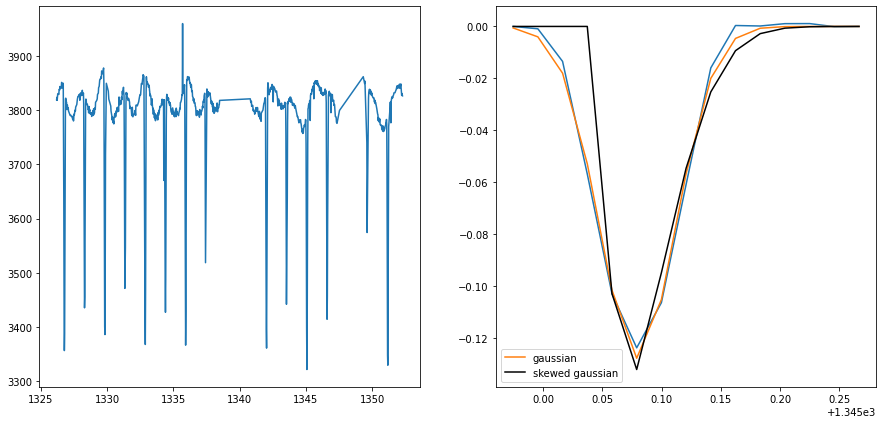

In [62]:
plot(data)

In [63]:
len(flux)

15

### Test interpolate

In [64]:
arange = np.linspace(time.min(),time.max(),5000)
interp = np.interp(arange,time,flux)

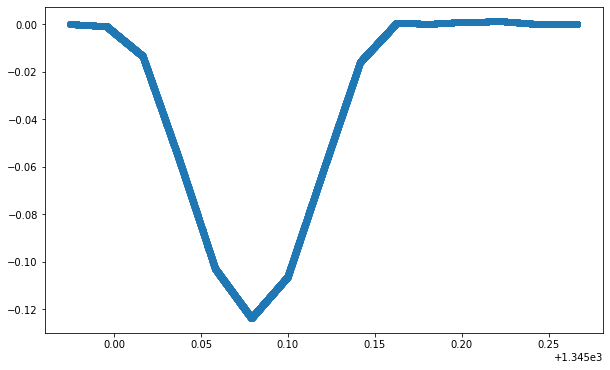

In [65]:
plt.scatter(arange,interp)